<a href="https://colab.research.google.com/github/PuchToTalk/LLM/blob/Mistral/marlin_mistral_ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Comprehensive Guide to Finetuning mistralai/mistral-7b-v0.1





## Introduction

In this notebook, we will walk through the process of fine-tuning a pre-trained model using the Hugging Face library. We will cover the essential steps from setting up the necessary plugins and accelerator to preparing the data and loading the model. By the end of this guide, you should have a foundational understanding of how to fine-tune models for custom tasks.

First, begin by importing the neccesary libraries.

### Prerequisites

This notebook requires at least GPU compute capability 7.0 to utilize the acceleration. 20xx series nvidia cards may serve as a baseline, but it will take a long time. My original utilization of this model was trained on a single 4090 in just under 1 hour.

This tutorial may have some install difficulties on Windows machines. Further testing will be done.

In [3]:
!pip install einops
!pip install accelerate
!pip install datasets
!pip install peft
!pip install trl
!pip install bitsandbytes
!pip install huggingface_hub
!pip install git+https://github.com/huggingface/transformers
!pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninst

### Import the libraries

Now that the required libraries are installed, you can import them to the notebook for use in the rest of the script.

In [4]:
pip install scipy

In [5]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
import torch
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from huggingface_hub import login


### Authentication

If you wish to upload the model to your huggingface hub account at the end of this tutorial then you will need to acquire an access token from huggingface_hub settings.

Optionally, you can just leave this out and opt-out of the last cell to not upload it.

In [6]:
pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00


In [7]:
login()

## Loading Accelerator

For efficient training, we will leverage the Fully Sharded Data Parallel Plugin and Accelerator. This will allow for optimized memory usage and potentially faster training times.

If you wish to do so, you can also plug in different accelerators in this cell to see how they effect training.

In [8]:
## Load accelerator
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

## Data Preparation

Next, we will load our training dataset, shuffle it, and split it into training, validation, and test subsets.

The dataset chosen for this fine tune is vicgalle/alpaca-gpt4, which contains English Instruction-Following generated by GPT-4 using Alpaca prompts for fine-tuning LLMs.

The dataset contains approximately 56k samples, of which we will only use 10k.

The following section is where you can import different datasets and perform some exploratory data analysis to decide what information you want to use to train.

In [9]:
# Load the full training dataset
full_train_dataset = load_dataset('vicgalle/alpaca-gpt4', split='train')

# Shuffle and select the first 10,000 samples
subset_dataset = full_train_dataset.shuffle(seed=42).select(range(10000))

# Split the subset into train, validation, and test sets
train_dataset = subset_dataset.train_test_split(test_size=0.2)['train']  # 8,000 samples for training
temp_dataset = subset_dataset.train_test_split(test_size=0.2)['test']   # 2,000 samples left
eval_dataset = temp_dataset.train_test_split(test_size=0.5)['train']    # 1,000 samples for validation
test_dataset = temp_dataset.train_test_split(test_size=0.5)['test']     # 1,000 samples for testing

# Print the datasets
print(train_dataset)
print(eval_dataset)
print(test_dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 8000
})
Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 1000
})
Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 1000
})


## Model and Tokenizer Loading

Load the base model with specific configurations and the tokenizer that will be used to preprocess our data.



In [10]:
## Load Base Model
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Tokenization Setup

In this section, we adjust the tokenizer settings and define a tokenization function to preprocess our dataset.

In [11]:

tokenizer = AutoTokenizer.from_pretrained(base_model_id)

# If the tokenizer does not have a padding token, set it as the EOS token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


from transformers import AutoTokenizer, AutoModelForCausalLM  # or the specific model you're using
tokenizer.pad_token = tokenizer.eos_token

def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

## Data Formatting

Next, we define a function to format each data sample into a specific structure suitable for our model's task.

This prompt template is designed to format the incoming data to the model.

In [12]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{data_point["instruction"]}

### Input:
{data_point["input"]}

### Response:
{data_point["output"]}
"""
    return tokenize(full_prompt)

## Data Tokenization

For our model to understand and process the data, we need to convert the raw data into a format that it understands. Tokenization breaks down the raw text into tokens, which are integer representations of words or characters.

In [13]:
# tokenize each sample based on the prompt format
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

print(tokenized_train_dataset[4]['input_ids'])

# check that the sample has the max length of 512
print(len(tokenized_train_dataset[4]['input_ids']))

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

[1, 20811, 349, 396, 13126, 369, 13966, 264, 3638, 28725, 5881, 1360, 395, 396, 2787, 369, 5312, 3629, 2758, 28723, 12018, 264, 2899, 369, 6582, 1999, 2691, 274, 272, 2159, 28723, 13, 27332, 3133, 3112, 28747, 13, 23342, 264, 15032, 2838, 970, 272, 18521, 392, 349, 264, 28001, 28723, 13, 13, 27332, 11232, 28747, 13, 13, 13, 27332, 12107, 28747, 13, 1313, 403, 264, 3199, 304, 9735, 28724, 2125, 28725, 304, 16941, 28725, 264, 28705, 28740, 28787, 28733, 4395, 28733, 738, 1486, 2052, 5716, 28725, 403, 1611, 4411, 1312, 559, 4386, 654, 1753, 356, 264, 1955, 6596, 28723, 985, 403, 2942, 298, 3232, 356, 559, 7193, 28725, 562, 272, 2622, 302, 272, 25752, 304, 272, 910, 1905, 5535, 654, 2492, 378, 3796, 28723, 985, 4496, 298, 1388, 264, 1721, 304, 3054, 741, 5046, 298, 10325, 559, 28686, 28723, 13, 13, 2198, 630, 972, 5885, 1059, 272, 11671, 28725, 630, 27907, 3714, 396, 1571, 15032, 5994, 28723, 661, 403, 684, 264, 1191, 10192, 6240, 369, 9107, 1332, 264, 2005, 28725, 304, 7577, 8215, 378, 40

## Evaluate the Base Model

Before fine-tuning, it's a good practice to evaluate the base model on our task to get a sense of its initial performance.

This way, you can design a prompt that can be validated against once we finish training the model.

In [14]:
print("Instruction: " + test_dataset[1]['instruction'])
print("Input: " + test_dataset[1]['input'])
print("Response: " + test_dataset[1]['output'] + "\n")

eval_prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{test_dataset[1]['instruction']}

### Input:
{test_dataset[1]['input']}

### Response:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
        print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

Instruction: Come up with an algorithm for predicting house prices in a given city.
Input: 
Response: An algorithm for predicting house prices in a given city can be designed as follows:

1. **Data Collection:** The first step is to gather data about house prices and their features in the given city. The data should include a comprehensive list of home characteristics such as square footage, the number of bedrooms, bathrooms, location, age, etc., along with their respective selling prices. This data can be collected from various sources such as real estate websites, government records or data providing companies that specialize in real estate data.

2. **Data Preprocessing:** After collecting the data, the next step is to clean and preprocess it. This step involves handling missing or invalid values, removing duplicates, converting text data into numerical values and normalizing the data. Preprocessing ensures that the data is in a format suitable for further analysis.

3. **Feature Se

## Begin Fine-tuning with PEFT

Next, we will start the fine-tuning process using PEFT. PEFT stands for "Progressive Embedding Fine-Tuning", a method that helps in optimizing the model's weights.

In [15]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# print model to examine layers
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

## Integrating LoRa

LoRa (Low-Rank Adapters) is a technique to train neural networks more efficiently by adding low-rank transformations to the intermediate representations of a pre-trained model.

In [16]:
# Define the LoRa config
config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 21260288 || all params: 3773331456 || trainable%: 0.5634354746703705


## Applying the Accelerator

To further optimize our model training, we apply the accelerator. This step optimizes the training across multiple devices if available.

In [17]:
# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

## Examining the Updated Model

After integrating LoRa and applying the accelerator, let's print the model to observe the changes.

In [18]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(
                in_features=4096, out_features=1024, bias=False
       

## Tracking Training with Weights & Biases (wandb)

Weights & Biases (wandb) provides tools to track and visualize the training process. By integrating with wandb, you can monitor your model's performance, visualize metrics, and more.

In [21]:
import locale

# Set the locale environment variables within Python
locale.setlocale(locale.LC_ALL, 'en_US.utf8')

# Then, you can check the current locale settings to verify the change
print(locale.getlocale())


('en_US', 'UTF-8')


In [24]:
## Track the training stats on wandb
import wandb, os
wandb.login()

wandb_project = "marlin-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Training the Model

Now, we'll start the fine-tuning process. This involves specifying various training parameters and using the Trainer class from the transformers library.

In [26]:
import transformers
from datetime import datetime

project = "marlin-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=50,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

wandb: Currently logged in as: paulchuparis (puch). Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,1.001900,0.831431
100,0.810800,0.808887
150,0.797300,0.785585
200,0.782900,0.773357
250,0.782800,0.768800
300,0.763200,0.765990
350,0.749700,0.763275
400,0.750300,0.759820
450,0.771100,0.757575
500,0.756300,0.756650


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=0.7720614585876465, metrics={'train_runtime': 5156.043, 'train_samples_per_second': 1.552, 'train_steps_per_second': 0.194, 'total_flos': 1.75274075357184e+17, 'train_loss': 0.7720614585876465, 'epoch': 1.0})

In [ ]:

OUTPUT_DIR = "experiments"
%load_ext tensorboard
%tensorboard --logdir experiments/runs

## Evaluating the Fine-tuned Model

After training, it's important to evaluate the fine-tuned model to understand its performance. This involves loading the base model and comparing its outputs to the fine-tuned model.

In [32]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the model and tokenizer
base_model_id = "mistralai/mistral-7b-v0.1"
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)

# Check if CUDA is available and choose device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device selected: {device}")

# Ensure the model is loaded onto the correct device
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True).to(device)

# Assuming 'model_input' is your input to the model, ensure it's on the same device as the model
model_input_on_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in model_input.items()}

# Now you can perform your inference
with torch.no_grad():
    output_tokens = base_model.generate(**model_input_on_device, max_length=100, pad_token_id=tokenizer.eos_token_id)
    output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

print(output_text)


Device selected: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
Come up with an algorithm for predicting house prices in a given city.

### Input:


### Response:







































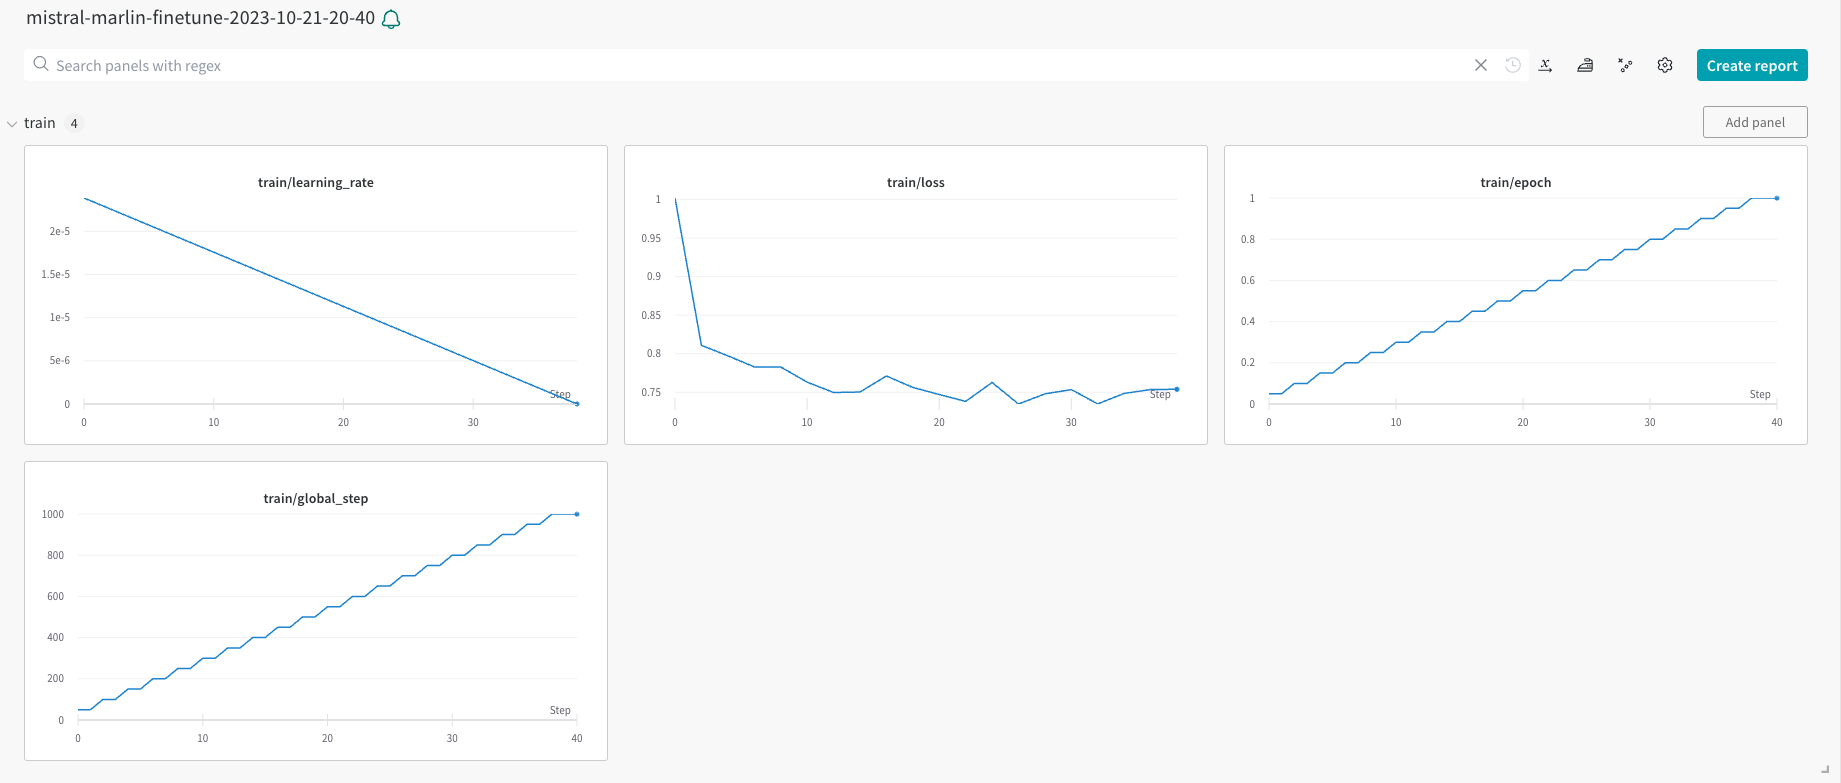

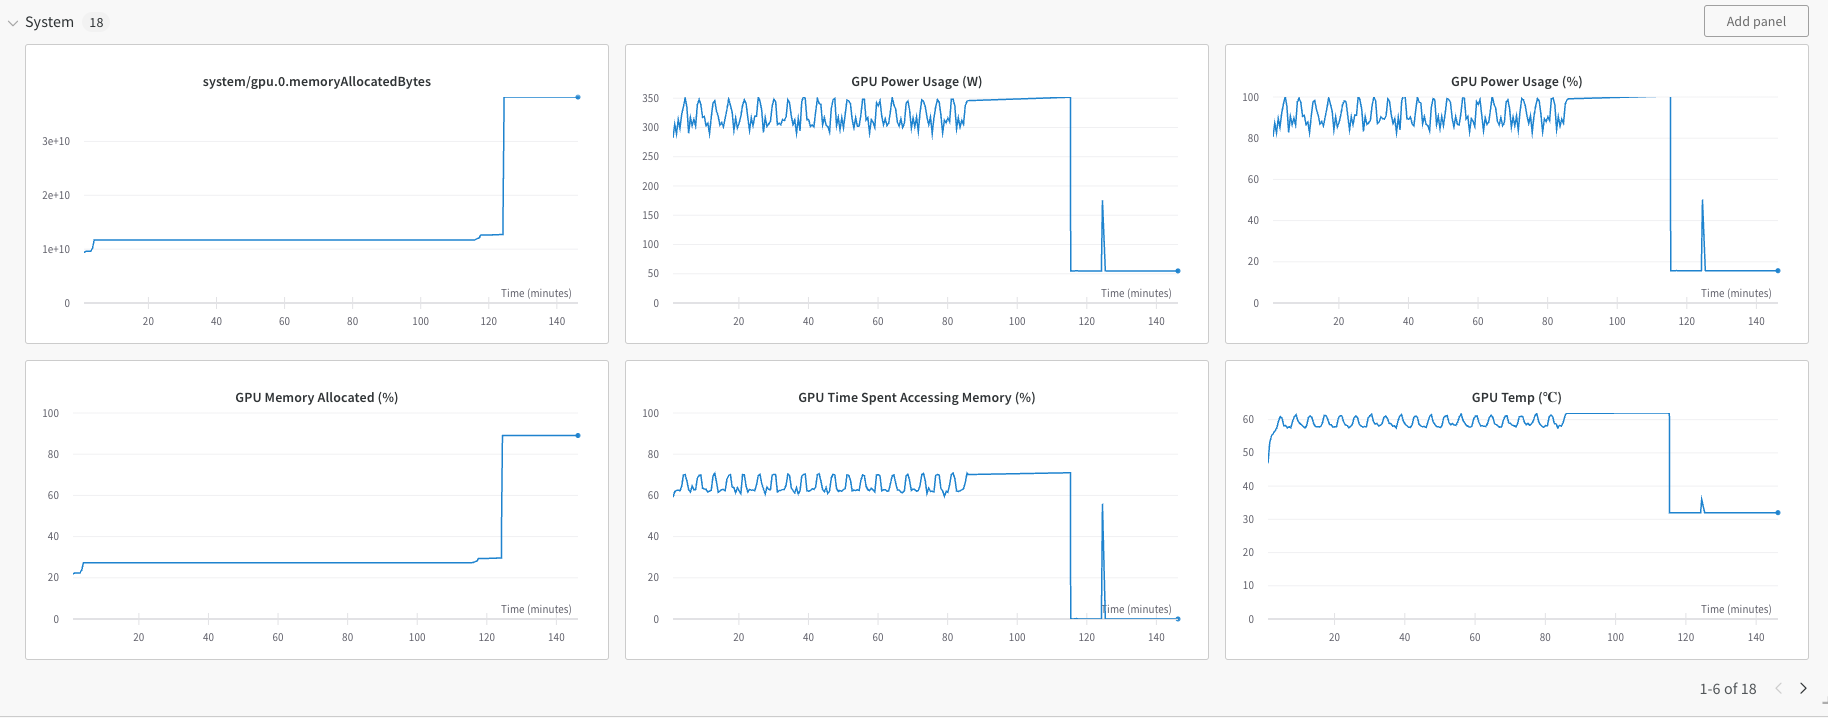

## Pushing the model to Huggingface Hub

At this point you have completed the fine tuning of mistral-7b-v0.1 on a Stanford Alpaca style dataset ranging a variety of topics. You can stop now if you wish.

However, there are a few more steps if you wish to upload the model to share your completion of this project.

You just need to merge the fine tuned model with the base model, and then push the merged model to your profile.

In [30]:
login()

In [37]:
ft_model.save_pretrained("./Puch_alpaca_Mistral7b")


In [39]:
import os

# Set the environment variable to specify UTF-8 encoding
os.environ['PYTHONIOENCODING'] = 'UTF-8'


In [43]:
save_directory = "/content/mistral-marlin-finetune"  # Colab's file system is reset after each session, so you don't need to worry about overwriting files

# Save model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('/content/mistral-marlin-finetune/tokenizer_config.json',
 '/content/mistral-marlin-finetune/special_tokens_map.json',
 '/content/mistral-marlin-finetune/tokenizer.json')

In [45]:
from huggingface_hub import notebook_login

notebook_login()

In [46]:
model.push_to_hub("Puch/alpaca-Mistral7b", use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:844: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.91G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/9.17G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Puch/alpaca-Mistral7b/commit/9dcbcfec0c6c4247c1d9f8318b122b5fa18031e8', commit_message='Upload MistralForCausalLM', commit_description='', oid='9dcbcfec0c6c4247c1d9f8318b122b5fa18031e8', pr_url=None, pr_revision=None, pr_num=None)